# Meta Learning

In this notebook, we will implement various algorithms from the paper [A Closer Look at Few-Shot Classification](https://openreview.net/pdf?id=HkxLXnAcFQ).

Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").

Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/meta/learning/2019/04/29/Fun-of-Dissecting-Paper/). 

#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Meta%20Learning/meta_learning_baseline%2B%2B.ipynb)

## Data

In [0]:
import os
import time
from pathlib import Path
import shutil
from os.path import join
from PIL import Image
import distutils.core

os.mkdir('dataset/')
path = Path('dataset/')

In [0]:
! wget -O images_background.zip https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip?raw=true

In [0]:
! wget -O images_evaluation.zip https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip?raw=true

In [0]:
! unzip -q -n images_background.zip -d {path}
! unzip -q -n images_evaluation.zip -d {path}

In [0]:
! wget https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/train.txt 
! wget https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/val.txt
! wget https://raw.githubusercontent.com/jakesnell/prototypical-networks/master/data/omniglot/splits/vinyals/test.txt

In [0]:
distutils.dir_util.copy_tree(str(path/'images_evaluation/'), str(path/'images_background'))

In [0]:
print ('Classes:', os.listdir(path/'images_background'))
print ('Total classes:', len(os.listdir(path/'images_background')))

Classes: ['Mongolian', 'Greek', 'Angelic', 'Mkhedruli_(Georgian)', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Sylheti', 'Burmese_(Myanmar)', 'Arcadian', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Grantha', 'Gujarati', 'Sanskrit', 'Atlantean', 'Kannada', 'Tifinagh', 'Malay_(Jawi_-_Arabic)', 'Keble', 'Japanese_(katakana)', 'Japanese_(hiragana)', 'Old_Church_Slavonic_(Cyrillic)', 'Alphabet_of_the_Magi', 'Futurama', 'ULOG', 'N_Ko', 'Early_Aramaic', 'Anglo-Saxon_Futhorc', 'Oriya', 'Syriac_(Estrangelo)', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Korean', 'Malayalam', 'Armenian', 'Ge_ez', 'Avesta', 'Aurek-Besh', 'Atemayar_Qelisayer', 'Latin', 'Tengwar', 'Asomtavruli_(Georgian)', 'Tibetan', 'Bengali', 'Cyrillic', 'Manipuri', 'Gurmukhi', 'Glagolitic', 'Balinese', 'Tagalog', 'Hebrew', 'Syriac_(Serto)', 'Braille']
Total classes: 50


In [0]:
path = Path(path/'images_background')

In [0]:
def rotate_images():
    dirs = sorted(os.listdir(path))
    for d in dirs:
        char_folder = os.listdir(path/d)
        for character in char_folder:
            for deg in [0, 90, 180, 270]:
                img_files = os.listdir(join(path, d, character))
                rot_folder = "rot%03d"%deg
                rot_folder_path = join(path, d, character, rot_folder)
                if not os.path.exists(rot_folder_path):
                    os.makedirs(rot_folder_path)
                for img in img_files:
                    if 'rot' not in img:
                        rot_img = Image.open(join(path, d, character, img)).rotate(deg)
                        rot_img.save(join(path, d, character, rot_folder, img))

In [0]:
start = time.time()
rotate_images()
print ('Preprocessing Rotation Time taken: %.2f'%(time.time()-start))

In [0]:
os.mkdir('data/')
os.mkdir('data/train')
os.mkdir('data/val')
os.mkdir('data/test')
data_path = Path('data/')

In [0]:
def split_train_val_test(file, q='train'):
    
    with open(file, 'r') as f:
        for line in f:
            shutil.move(str(path/line.split('\n')[0]), join(data_path, q, line.split('\n')[0]))

In [0]:
split_train_val_test('train.txt', 'train')

In [0]:
split_train_val_test('val.txt', 'val')

In [0]:
split_train_val_test('test.txt', 'test')

In [0]:
print ('After splitting number of classes for train, val and test:')
len(os.listdir('data/train/')), len(os.listdir('data/val/')), len(os.listdir('data/test/'))

After splitting number of classes for train, val and test:


(33, 5, 13)

In [0]:
!tar -cvf dataset.tar /content/data

In [0]:
! pip install pydrive

In [0]:
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# upload = drive.CreateFile({'title': 'dataset.tar'})
# upload.SetContentFile('dataset.tar')
# upload.Upload()

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

download = drive.CreateFile({'id': '19Jinmzv_JNEhOVHg5CZMcgbexzTi4oEC'})
download.GetContentFile('dataset.tar')

In [0]:
! tar -xf dataset.tar

## Baseline++

We will start with implementing baseline++ algorithm mentioned in the [paper](https://openreview.net/pdf?id=HkxLXnAcFQ).

![baselineplusplus_implement](meta_learning/baseline_plusplus_implement.png "baselineplusplus_implement")
![train-stage](meta_learning/training_stage.png "train-stage")
![fine-tune](meta_learning/finetune_stage.png "finetune-stage")


![figure](meta_learning/train_finetune.png "figure")
![baseline++_classifier](meta_learning/baseline_plusplus.png "classifier")


![implement](meta_learning/implementation.png "implement")

![omniglot](meta_learning/omniglot.png "omniglot")


![result](meta_learning/results_total.png "result")


### Data Preprocessing

In [0]:
import pandas as pd
import os
from os.path import join
import glob
from pathlib import Path
import operator
from functools import reduce
import matplotlib.pyplot as plt
import random
import numpy as np
import imageio
%matplotlib inline

data_path = Path('/content/content/data/')

In [0]:
df_train = pd.DataFrame()
df_val = pd.DataFrame()
df_test = pd.DataFrame()

In [0]:
def read_labels(file, q='train'):
    
    with open(file, 'r') as f:
        lines = f.read().splitlines() 
    return lines

def blow_up_labels(lbl):
    flat_labels = []
    for i, l in enumerate(lbl):
        for _ in range(20):
            flat_labels.append(l)
    return flat_labels

In [0]:
trn_lbl = sorted(read_labels('train.txt', 'train'))
print ('Training Classes:', len(trn_lbl))
df_train['labels'] = blow_up_labels(trn_lbl)

Training Classes: 4112


In [0]:
val_lbl = sorted(read_labels('val.txt', 'val'))
print ('Validation Classes:', len(val_lbl))
df_val['labels'] = blow_up_labels(val_lbl)

Validation Classes: 688


In [0]:
test_lbl = sorted(read_labels('test.txt', 'test'))
print ('Test Classes:', len(test_lbl))
df_test['labels'] = blow_up_labels(test_lbl)

Test Classes: 1692


In [0]:
def read_image_paths(q='train'):
    paths = []
    dirs = sorted(os.listdir(data_path/q))
    for d in dirs:
        character_folder = sorted(os.listdir(join(data_path, q, d)))
        for c in character_folder:
            rot_folder = sorted(os.listdir(join(data_path, q, d, c)))
            for r in rot_folder:
                paths.append(sorted(glob.glob(join(data_path, q, d, c, r, '*.png'))))
    return paths

In [0]:
trn_img_list = read_image_paths('train')
flat_img_list = reduce(operator.concat, trn_img_list)
df_train['img_paths'] = flat_img_list

In [0]:
val_img_list = read_image_paths('val')
flat_img_list = reduce(operator.concat, val_img_list)
df_val['img_paths'] = flat_img_list

In [0]:
test_img_list = read_image_paths('test')
flat_img_list = reduce(operator.concat, test_img_list)
df_test['img_paths'] = flat_img_list

In [0]:
trn_lbl_map = dict(zip(trn_lbl, np.array(range(len(trn_lbl)))))
val_lbl_map = dict(zip(val_lbl, np.array(range(len(val_lbl)))))
test_lbl_map = dict(zip(test_lbl, np.array(range(len(test_lbl)))))

In [0]:
trn_dict = dict(zip(trn_lbl, trn_img_list))
val_dict = dict(zip(val_lbl, val_img_list))
test_dict = dict(zip(test_lbl, test_img_list))

In [0]:
def show_images(img_path, classes, rows=2, columns=4):
    fig=plt.figure(figsize=(18, 9))
    for i in range(1, columns*rows+1):
        img = imageio.imread(img_path[i-1])    
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label : {classes[i-1]}')
        plt.axis('off')

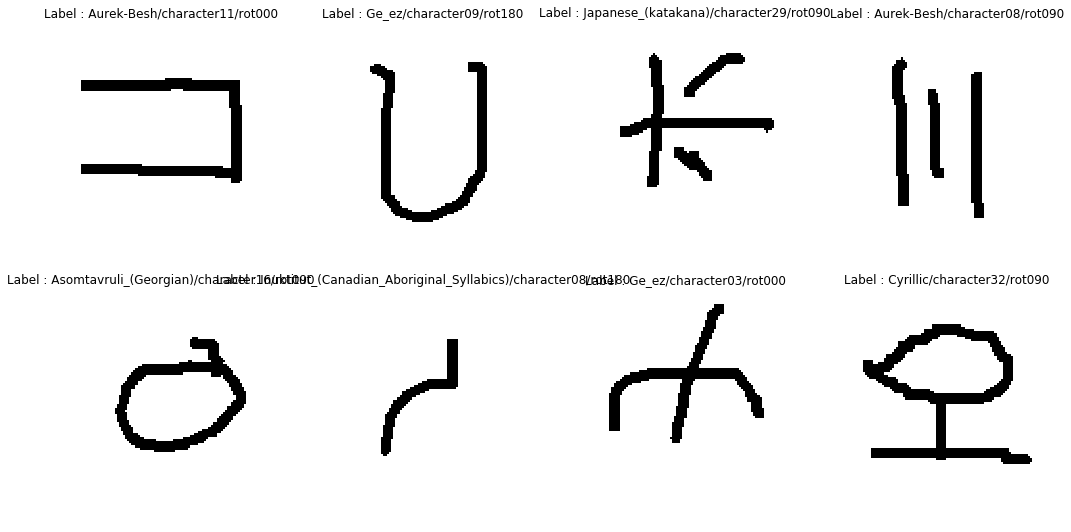

In [0]:
#randomly sample 8 images from train dataset
rnd_num = random.sample(list(np.arange(len(df_train))), 8)
rnd_files = df_train['img_paths'].iloc[rnd_num].values
rnd_lbls = df_train['labels'].iloc[rnd_num].values
show_images(rnd_files, rnd_lbls)

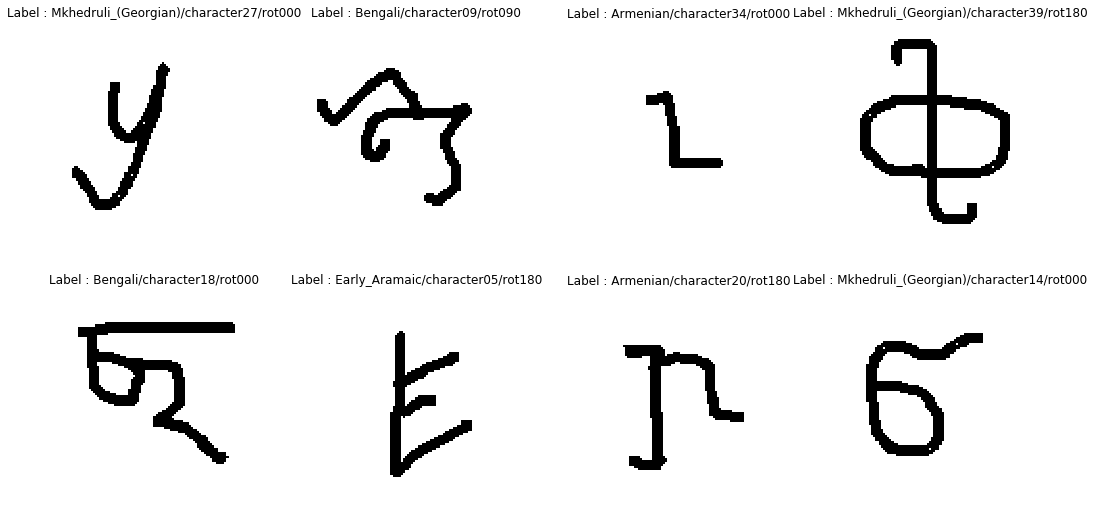

In [0]:
#randomly sample 8 images from val dataset
rnd_num = random.sample(list(np.arange(len(df_val))), 8)
rnd_files = df_val['img_paths'].iloc[rnd_num].values
rnd_lbls = df_val['labels'].iloc[rnd_num].values
show_images(rnd_files, rnd_lbls)

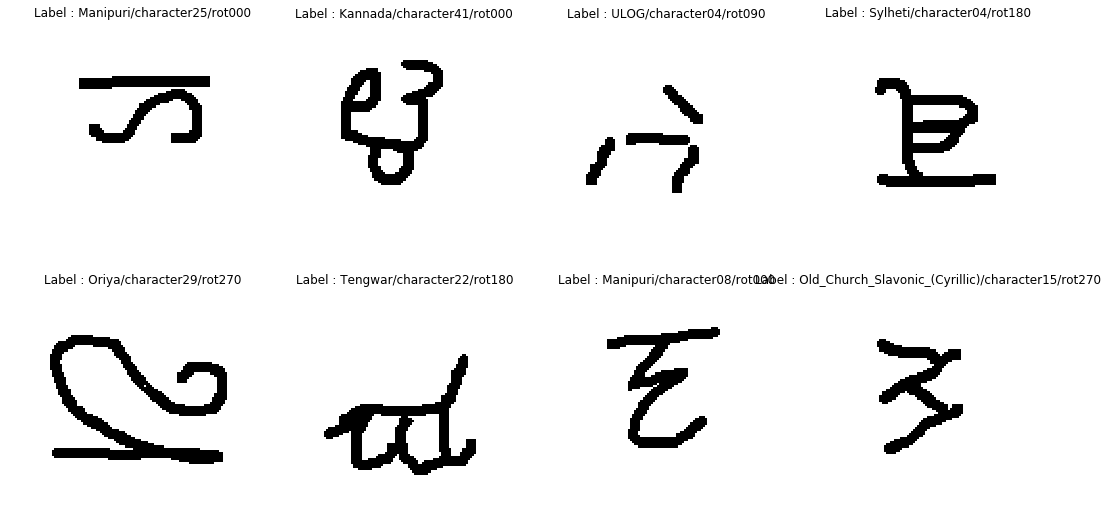

In [0]:
#randomly sample 8 images from test dataset
rnd_num = random.sample(list(np.arange(len(df_test))), 8)
rnd_files = df_test['img_paths'].iloc[rnd_num].values
rnd_lbls = df_test['labels'].iloc[rnd_num].values
show_images(rnd_files, rnd_lbls)

In [0]:
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import math
import torch.nn.functional as F
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.nn.utils.weight_norm import WeightNorm
from abc import abstractmethod
from PIL import Image

In [0]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    #
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    np.random.seed(seed)

enforce_reproducibility()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print (device)
batch_size = 16

cuda:0


### Custom Dataset

In [0]:
class FewShotDataset(data.Dataset):
    
    def __init__(self, split='train', transforms=None, target_transforms=None):     
        self.split = split
        self.transforms = transforms
        self.target_transforms = target_transforms
        self.img_paths = df_train['img_paths'].values if split == 'train' else df_val['img_paths'].values
        self.labels = df_train['labels'].values if split == 'train' else df_val['labels'].values
        self.data_dict = trn_dict if split == 'train' else val_dict
        self.label_map = trn_lbl_map if split == 'train' else val_lbl_map
        if split == 'test':
            self.img_paths = df_test['img_paths'].values
            self.labels = df_test['labels'].values
            self.data_dict = test_dict
            self.label_map = test_lbl_map
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        raise NotImplementedError("This is abstract class. Not implemented yet!")

In [0]:
class Omniglot(FewShotDataset):
      
    def __init__(self, *args, **kwargs):
        super(Omniglot, self).__init__(*args, **kwargs)
        
    def load_image(self, idx):
        im = Image.open(self.img_paths[idx]).convert('L')
        im = im.resize((28, 28), resample=Image.LANCZOS)
        im = np.array(im, dtype=np.float32)
        return im
    
    def __getitem__(self, idx):
        im = self.load_image(idx)
        if self.transforms is not None:
            im = self.transforms(im)
        label = self.label_map[self.labels[idx]]
        if self.target_transforms is not None:
            label = self.target_transforms(label)
        return im, label

### Custom DataLoader

In [0]:
class Dataloader:
    @abstractmethod
    def get_data_loader(self, split='train'):
        pass 

In [0]:
class FulldataLoader(Dataloader):
    
    def __init__(self, batch_size):
        super(FulldataLoader, self).__init__()
        self.batch_size = batch_size
    
    def get_data_loader(self, split='train'):
        dataset = Omniglot(split=split, transforms=transforms.Compose([transforms.ToTensor()]))
        data_loader_params = dict(batch_size = self.batch_size, shuffle = True, num_workers = 0, pin_memory = True)       
        data_loader = torch.utils.data.DataLoader(dataset, **data_loader_params)
        return data_loader

In [0]:
train_l = FulldataLoader(batch_size)
train_loader = train_l.get_data_loader(split='train')

In [0]:
val_l = FulldataLoader(batch_size)
val_loader = val_l.get_data_loader(split='val')

### Baseline++ Model 

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):        
        return x.view(x.size(0), -1)
    
def init_layer(L):
    # Initialization using fan-in
    if isinstance(L, nn.Conv2d):
        n = L.kernel_size[0]*L.kernel_size[1]*L.out_channels
        L.weight.data.normal_(0,math.sqrt(2.0/float(n)))
    elif isinstance(L, nn.BatchNorm2d):
        L.weight.data.fill_(1)
        L.bias.data.fill_(0)    

In [0]:
class distLinear(nn.Module):
    def __init__(self, indim, outdim):
        super(distLinear, self).__init__()
        self.L = nn.Linear( indim, outdim, bias=False)
        self.class_wise_learnable_norm = True  #See the issue#4&8 in the github 
        if self.class_wise_learnable_norm:      
            WeightNorm.apply(self.L, 'weight', dim=0) #split the weight update component to direction and norm      

        if outdim <=200:
            self.scale_factor = 2; #a fixed scale factor to scale the output of cos value into a reasonably large input for softmax
        else:
            self.scale_factor = 10; #in omniglot, a larger scale factor is required to handle >1000 output classes.

    def forward(self, x):
        x_norm = torch.norm(x, p=2, dim=1).unsqueeze(1).expand_as(x)
        x_normalized = x.div(x_norm+ 0.00001)
        if not self.class_wise_learnable_norm:
            L_norm = torch.norm(self.L.weight.data, p=2, dim =1).unsqueeze(1).expand_as(self.L.weight.data)
            self.L.weight.data = self.L.weight.data.div(L_norm + 0.00001)
        cos_dist = self.L(x_normalized) #matrix product by forward function, but when using WeightNorm, this also multiply the cosine distance by a class-wise learnable norm, see the issue#4&8 in the github
        scores = self.scale_factor* (cos_dist) 

        return scores

In [0]:
# Simple Conv Block
class ConvBlock(nn.Module):
    def __init__(self, indim, outdim, pool = True, padding = 1):
        super(ConvBlock, self).__init__()
        self.indim  = indim
        self.outdim = outdim
        self.C      = nn.Conv2d(indim, outdim, 3, padding= padding)
        self.BN     = nn.BatchNorm2d(outdim)
        self.relu   = nn.ReLU(inplace=True)

        self.parametrized_layers = [self.C, self.BN, self.relu]
        if pool:
            self.pool   = nn.MaxPool2d(2)
            self.parametrized_layers.append(self.pool)

        for layer in self.parametrized_layers:
            init_layer(layer)

        self.trunk = nn.Sequential(*self.parametrized_layers)

    def forward(self, x):
        out = self.trunk(x)
        return out

In [0]:
class ConvNetS(nn.Module): #For omniglot, only 1 input channel, output dim is 64
    def __init__(self, depth, flatten = True):
        super(ConvNetS, self).__init__()
        trunk = []
        for i in range(depth):
            indim = 1 if i == 0 else 64
            outdim = 64
            B = ConvBlock(indim, outdim, pool = ( i<4 ) ) #only pooling for fist 4 layers
            trunk.append(B)

        if flatten:
            trunk.append(Flatten())

        self.trunk = nn.Sequential(*trunk)
        self.final_feat_dim = 64

    def forward(self, x):
        out = x[:,0:1,:,:] #only use the first dimension
        out = self.trunk(out)
        return out

In [0]:
Conv4 = ConvNetS(4).to(device)

In [0]:
class BaselineplusplusTrain(nn.Module):
    def __init__(self, model_func, num_class, loss_type = 'dist'):
        super(BaselineplusplusTrain, self).__init__()
        self.feature    = model_func
        self.classifier = distLinear(self.feature.final_feat_dim, num_class)
        self.loss_type = loss_type  #'dist'
        self.num_class = num_class
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x    = Variable(x.cuda())
        out  = self.feature.forward(x)
        scores  = self.classifier.forward(out)
        return scores

    def forward_loss(self, x, y):
        scores = self.forward(x)
        y = Variable(y.cuda())
        return self.loss_fn(scores, y )
    
    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10
        avg_loss = 0

        for i, (x,y) in enumerate(train_loader):
            optimizer.zero_grad()
            loss = self.forward_loss(x, y)
            loss.backward()
            optimizer.step()

            avg_loss = avg_loss+loss.item()

            if i % print_freq==0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader), avg_loss/float(i+1)))
                     
    def test_loop(self, val_loader):
        return -1 #no validation, just save model during iteration

In [0]:
base_model = BaselineplusplusTrain(Conv4, num_class=4112).to(device)

In [0]:
optimizer = torch.optim.Adam(base_model.parameters())

### Training

In [0]:
def train(model, train_dataloader, val_dataloader, optimizer, epochs=5):
    
    max_acc = 0       
    checkpoint_dir = '/content/logs'
    save_freq = 1
    
    for epoch in range(epochs):
        model.train()
        model.train_loop(epoch, train_loader, optimizer) #model are called by reference, no need to return 
        model.eval()

        if not os.path.isdir(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        acc = model.test_loop(val_loader)
        if acc > max_acc : #for baseline++, we don't use validation here so we let acc = -1
            print("best model! save...")
            max_acc = acc
            outfile = os.path.join(checkpoint_dir, 'best_model.tar')
            torch.save({'epoch':epoch, 'state':model.state_dict()}, outfile)

        if (epoch % save_freq==0) or (epoch==epochs-1):
            outfile = os.path.join(checkpoint_dir, '{:d}.tar'.format(epoch))
            torch.save({'epoch':epoch, 'state':model.state_dict()}, outfile)
            
    return model

In [0]:
model = train(base_model, train_loader, val_loader, optimizer, epochs=5)

### Finetune

In [0]:
def get_nway_data(data_dict, n_way=5, n_support=5, n_query=15, split='val'):
    support = []
    query = []
    x = [[] for _ in range(n_way)]
    keys = [k for k, v in data_dict.items()]
    
    rnd_cls_index = np.random.choice(len(keys), n_way, False)
    #print (rnd_cls_index)
   
    for ix, c in enumerate(rnd_cls_index):
        #print (keys[c])
        imgs = np.array(data_dict[keys[c]])
        #print (len(imgs))
        rnd_imgs_index = np.random.choice(len(imgs), n_support+n_query, False)
        #print (rnd_imgs_index)
        support.append(imgs[rnd_imgs_index[:n_support]])
        query.append(imgs[rnd_imgs_index[n_support:]])
        
        for i in rnd_imgs_index:
            im = Image.open(imgs[i]).convert('L')
            im = im.resize((28, 28), resample=Image.LANCZOS)
            arr = np.array(im, np.float32)
            arr = np.reshape(im, (1, 28, 28))
             
            x[ix].append(arr)
    return np.array(x)

In [0]:
x = get_nway_data(val_dict)
x = torch.from_numpy(x).float()

In [0]:
class BaselineplusplusFinetune(nn.Module):
    def __init__(self, model_func, n_way, n_support, n_query):
        super(BaselineplusplusFinetune, self).__init__()
        self.n_way      = n_way
        self.n_support  = n_support
        self.n_query    = n_query 
        self.feature    = model_func
        self.feat_dim   = self.feature.final_feat_dim

    def set_forward(self, x, is_feature = True):
        return self.set_forward_adaptation(x, is_feature) #Baseline always do adaptation

    def forward(self, x):
        out  = self.feature.forward(x)
        return out

    def parse_feature(self, x, is_feature=False):
        x    = Variable(x.to(device))
        if is_feature:
            z_all = x
        else:
            x           = x.contiguous().view(self.n_way * (self.n_support + self.n_query), *x.size()[2:])
            z_all       = self.feature.forward(x)
            z_all       = z_all.view( self.n_way, self.n_support + self.n_query, -1)
        z_support   = z_all[:, :self.n_support]
        z_query     = z_all[:, self.n_support:]

        return z_support, z_query

    def set_forward_adaptation(self, x, is_feature = False): #further adaptation, default is fixing feature and train a new dist clasifier
        z_support, z_query  = self.parse_feature(x, is_feature)

        z_support   = z_support.contiguous().view(self.n_way* self.n_support, -1 )
        z_query     = z_query.contiguous().view(self.n_way* self.n_query, -1 )

        y_support = torch.from_numpy(np.repeat(range(self.n_way), self.n_support))
        y_support = Variable(y_support.to(device))

        linear_clf = distLinear(self.feat_dim, self.n_way)
        linear_clf = linear_clf.to(device)

        set_optimizer = torch.optim.SGD(linear_clf.parameters(), lr = 0.01, momentum=0.9, dampening=0.9, weight_decay=0.001)

        loss_function = nn.CrossEntropyLoss()
        loss_function = loss_function.to(device)
        
        batch_size = 4
        support_size = self.n_way * self.n_support
        for epoch in range(100):
            rand_id = np.random.permutation(support_size)
            for i in range(0, support_size , batch_size):
                set_optimizer.zero_grad()
                selected_id = torch.from_numpy(rand_id[i: min(i+batch_size, support_size)]).to(device)
                z_batch = z_support[selected_id]
                y_batch = y_support[selected_id] 
                scores = linear_clf(z_batch)
                loss = loss_function(scores,y_batch)
                loss.backward(retain_graph=True)
                set_optimizer.step()

        scores = linear_clf(z_query)
        return scores

In [0]:
modelfile = os.path.join('/content/logs', '4.tar')

tmp = torch.load(modelfile)
state = tmp['state']
state_keys = list(state.keys())

for i, key in enumerate(state_keys):
    if "feature." in key:
        newkey = key.replace("feature.","")  # an architecture model has attribute 'feature', load architecture feature to backbone by casting name from 'feature.trunk.xx' to 'trunk.xx'  
        state[newkey] = state.pop(key)
    else:
        state.pop(key)

Conv4.load_state_dict(state)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
finetune_model = BaselineplusplusFinetune(Conv4, n_way=5, n_support=5, n_query=15)

In [0]:
scores = finetune_model.set_forward_adaptation(x, is_feature=False)

In [0]:
n_way = 5
n_query = 15
pred = scores.data.cpu().numpy().argmax(axis = 1)
y = np.repeat(range(n_way), n_query )
acc = np.mean(pred == y)*100 
print (acc)

82.66666666666667


### Results

![header](meta_learning/header.png "header")
![baseline_res](meta_learning/baseline_plusplus_result.png "res")


### 5-shot 5-way

In [0]:
from tqdm import tqdm
num_iters = 600
acc_all = []
n_way = 5
n_query = 15
for _ in tqdm(range(num_iters)):
    x = get_nway_data(val_dict)
    x = torch.from_numpy(x).float()
    scores = finetune_model.set_forward_adaptation(x, is_feature=False)    
    pred = scores.data.cpu().numpy().argmax(axis = 1)
    y = np.repeat(range(n_way), n_query )
    acc = np.mean(pred == y)*100 
    acc_all.append(acc)

100%|██████████| 600/600 [2:17:02<00:00, 15.41s/it]


In [0]:
acc_all  = np.asarray(acc_all)
acc_mean = np.mean(acc_all)
acc_std  = np.std(acc_all)
print('%d Test Acc = %4.2f%% +- %4.2f%%' %(num_iters,  acc_mean, 1.96*acc_std/np.sqrt(num_iters)))

600 Test Acc = 99.32% +- 0.13%


###  1-shot 5-way

In [0]:
from tqdm import tqdm
num_iters = 600
acc_all = []
n_way = 5
n_query = 15
n_support = 1
finetune_model = BaselineplusplusFinetune(Conv4, n_way=5, n_support=1, n_query=15)

for _ in tqdm(range(num_iters)):
    x = get_nway_data(val_dict, n_way, n_support, n_query)
    x = torch.from_numpy(x).float()
    scores = finetune_model.set_forward_adaptation(x, is_feature=False)    
    pred = scores.data.cpu().numpy().argmax(axis = 1)
    y = np.repeat(range(n_way), n_query)
    acc = np.mean(pred == y)*100 
    acc_all.append(acc)

100%|██████████| 600/600 [07:50<00:00,  1.28it/s]


In [0]:
acc_all  = np.asarray(acc_all)
acc_mean = np.mean(acc_all)
acc_std  = np.std(acc_all)
print('%d Test Acc = %4.2f%% +- %4.2f%%' %(num_iters,  acc_mean, 1.96*acc_std/np.sqrt(num_iters)))

600 Test Acc = 94.29% +- 0.50%


## Test Samples

In [0]:
test_x = get_nway_data(test_dict, split='test')
test_x = torch.from_numpy(test_x).float()

In [0]:
finetune_model = BaselineplusplusFinetune(Conv4, n_way=5, n_support=5, n_query=15)

In [0]:
scores = finetune_model.set_forward_adaptation(test_x, is_feature=False)

In [0]:
n_way = 5
n_query = 15
pred = scores.data.cpu().numpy().argmax(axis = 1)
y = np.repeat(range(n_way), n_query)
acc = np.mean(pred == y)*100 
print (acc)

98.66666666666667


### Choose a class to visualize

In [0]:
# batch size : [5, 20, 1, 28, 28]
# classes 0, 1, 2, 3, 4
# support images first 5
# query images next 15
# each image of size (28, 28, 1)
choose_class = 3

In [0]:
# visualize support images
support_imgs = test_x[choose_class, 0:5]
# visualize query images only
query_imgs = test_x[choose_class, 5:20]

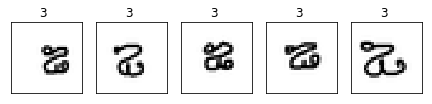

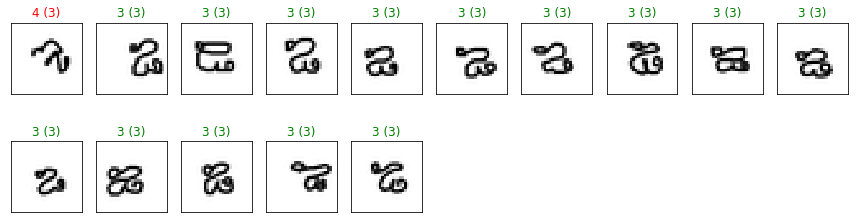

In [0]:
# get sample outputs
labels = y[choose_class*15:choose_class*15+15]
support_lbl = np.ones(len(support_imgs), dtype=np.int16) * choose_class
# get output i.e., predicted class
preds = pred[choose_class*15:choose_class*15+15]
# prep images for display
s_images = support_imgs.cpu().numpy()
q_images = query_imgs.cpu().numpy()


# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(s_images[idx]), cmap='gray')
    ax.set_title("{} ".format(str(support_lbl[idx])))

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(15):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(q_images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))